In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using StatsPlots
using Distances

In [3]:
df = collect_results(datadir("sims/repeated_evolution_consistent_start"));

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_consistent_start for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/GrTVT/src/result_collection.jl:115
┌ Warning: type Tuple{Population{Tuple{Float64, Float64}},EvoTrace} does not exist in workspace; interpreting Array{Tuple{Population{Tuple{Float64, Float64}},EvoTrace}} as Array{Any}
└ @ JLD2 /Users/boothh/.julia/packages/JLD2/rAnWX/src/datasets.jl:268


┌ Warning: type parameters for Population{Tuple{Float64, Float64}} do not match type Population in workspace; reconstructing
└ @ JLD2 /Users/boothh/.julia/packages/JLD2/rAnWX/src/data/reconstructing_datatypes.jl:453
┌ Info: Added 2 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/GrTVT/src/result_collection.jl:191


In [4]:
names(df)

11-element Vector{String}:
 "noise_σ"
 "max_gen"
 "describe_proportion_mutants_rejected"
 "mutation_method"
 "n_max_iters_reached"
 "noise_method"
 "target"
 "raw_data"
 "β"
 "n_traj"
 "path"

In [5]:
headings = ["target",
            "n_traj",
            "max_gen",
            "β",
            "noise_σ",
            "mutation_method",
            "noise_method",
            "n_max_iters_reached",
            "describe_proportion_mutants_rejected"];

In [6]:
df[:,headings]

Row,target,n_traj,max_gen,β,noise_σ,mutation_method,noise_method,n_max_iters_reached,describe_proportion_mutants_rejected
,Array…?,Int64?,Int64?,Float64?,Float64?,String?,String?,Int64?,SummaryS…?
1,"[10.0, 50.0, 40.0]",10000,10000,Inf,1.0,all_viable,additive,1,Summary Stats:\nLength: 10000\nMissing Count: 0\nMean: 0.079610\nMinimum: 0.000000\n1st Quartile: 0.039999\nMedian: 0.068278\n3rd Quartile: 0.103675\nMaximum: 0.546045\n
2,"[10.0, 50.0, 40.0]",10000,10000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 10000\nMissing Count: 0\nMean: 0.078885\nMinimum: 0.000000\n1st Quartile: 0.038839\nMedian: 0.067688\n3rd Quartile: 0.103064\nMaximum: 0.511449\n


In [7]:
raw_data = df[:,"raw_data"][2];

In [8]:
all_w = map(x->x[1].dominant_individual.genotype.p[1],raw_data);

In [9]:
weight_counts = zeros(length(all_w),12)

for s in 1:length(all_w)
    for wi in 1:12
        weight_counts[s,wi] = reshape(all_w[s],12)[wi]
    end
end

In [10]:
start_network =  [ 2.46532  -2.18916   -0.482151  0.100882;
0.0       0.336411   0.0       0.0;
3.8411   -5.86916    0.0       0.0]

3×4 Matrix{Float64}:
 2.46532  -2.18916   -0.482151  0.100882
 0.0       0.336411   0.0       0.0
 3.8411   -5.86916    0.0       0.0

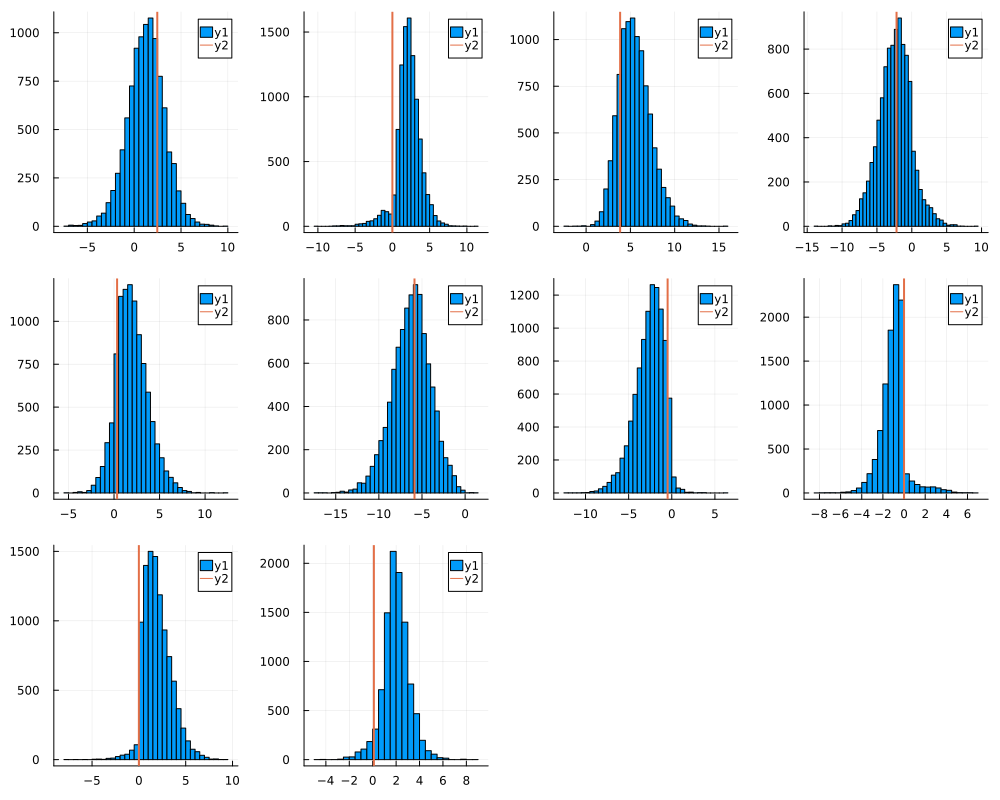

In [11]:
plot_list = []

start_network_flattened = reshape(start_network,(1,12))

for i in 1:10
    p = histogram(weight_counts[:,i:i],bins = 50,size = (1000,800))
    vline!(p,[start_network_flattened[i]],linewidth = 2.)
    push!(plot_list,p)
end

plot(plot_list...,layout = 10)

In [12]:
# corrplot(weight_counts[:,1:10], bins = 20,size = (1500,1500))

In [13]:
# cornerplot(weight_counts[:,1:10], compact=true,size = (1500,1500),bins = 50)

In [14]:
w_vec(w) = reverse(vec(Int.(sign.(w) .+ 1)))
vec_b3(v) = foldl((x,y) -> 3*x+y, v)

w_b3(w) = vec_b3(w_vec(w))

w_b3 (generic function with 1 method)

In [15]:
start_network =  [ 2.46532  -2.18916   -0.482151  0.100882;
                    0.0       0.336411   0.0       0.0;
                    3.8411   -5.86916    0.0       0.0]


start_vec = w_vec(start_network)

start_topology = w_b3(start_network)

end_topologies = map(x->w_b3(x),all_w);

end_distances = map(x->hamming(w_vec(x),start_vec),all_w);

end_top_distances = map(x->(w_b3(x),hamming(w_vec(x),start_vec)),all_w);

One topology dominates within each hamming distance?

In [16]:
topology_count = countmap(end_top_distances)
sort(collect(topology_count), by=x->x[2])

93-element Vector{Pair{Tuple{Int64, Int64}, Int64}}:
 (236276, 6) => 1
 (253718, 5) => 1
 (293298, 5) => 1
 (277260, 6) => 1
 (240758, 4) => 1
 (275796, 5) => 1
 (293274, 6) => 1
 (249398, 6) => 1
 (290220, 7) => 1
 (251012, 6) => 1
             ⋮
 (253874, 4) => 79
 (253928, 5) => 107
 (293240, 3) => 117
 (288924, 5) => 155
 (288708, 5) => 201
 (288926, 4) => 431
 (288710, 4) => 553
 (288870, 4) => 1950
 (288872, 3) => 5468

Why arent there any fit phenotypes with hamming distance < 3 ? Restrict mutation within topology.

In [17]:
distance_count = countmap(end_distances)
sort(collect(distance_count), by=x->x[2])

5-element Vector{Pair{Int64, Int64}}:
 7 => 3
 6 => 99
 5 => 831
 4 => 3328
 3 => 5739

In [18]:
all_fitness = map(x->x[2].fitness_trajectory,raw_data);

In [19]:
all_class = map(x->map(y->y[3],x),all_fitness);

In [31]:
function get_centres_and_width(v)
    return [v[1] + 0.5*v[2], v[2]]
end

# pheno_path_cw = map(x->get_centres_and_width(x),all_class[1]);

# f = plot(pheno_path_cw,seriestype = :path,xaxis = "centre position",yaxis = "width",size = (1000,1000),color = :blue)
# # scatter!(f,collect(keys(countmap(pheno_path_cw))),zcolor = Float64.(collect(values(countmap(pheno_path_cw)))) ./ length(pheno_path_cw))

# for i in 2:length(all_class)

#     pheno_path_cw = map(x->get_centres_and_width(x),all_class[i]);

#     plot!(f,pheno_path_cw,seriestype = :path,xaxis = "centre position",yaxis = "width", color = :blue)
#     # scatter!(f,collect(keys(countmap(pheno_path_cw))),zcolor = Float64.(collect(values(countmap(pheno_path_cw)))) ./ length(pheno_path_cw))

# end


get_centres_and_width (generic function with 1 method)

In [32]:
cw = map(x->map(y->get_centres_and_width(y),x),all_class);

all_cw = reduce(vcat,cw);

filter!(x->x!=[47.5, 19.0],all_cw);

all_cw_m = reduce(hcat,all_cw);

10000-element Vector{Vector{Vector{Float64}}}:
 [[47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0]  …  [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [34.5, 47.0], [33.5, 49.0]]
 [[47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0]  …  [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [33.5, 51.0], [34.0, 50.0]]
 [[47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0]  …  [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [36.5, 51.0], [33.5, 49.0]]
 [[47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0], [47.5, 19.0]

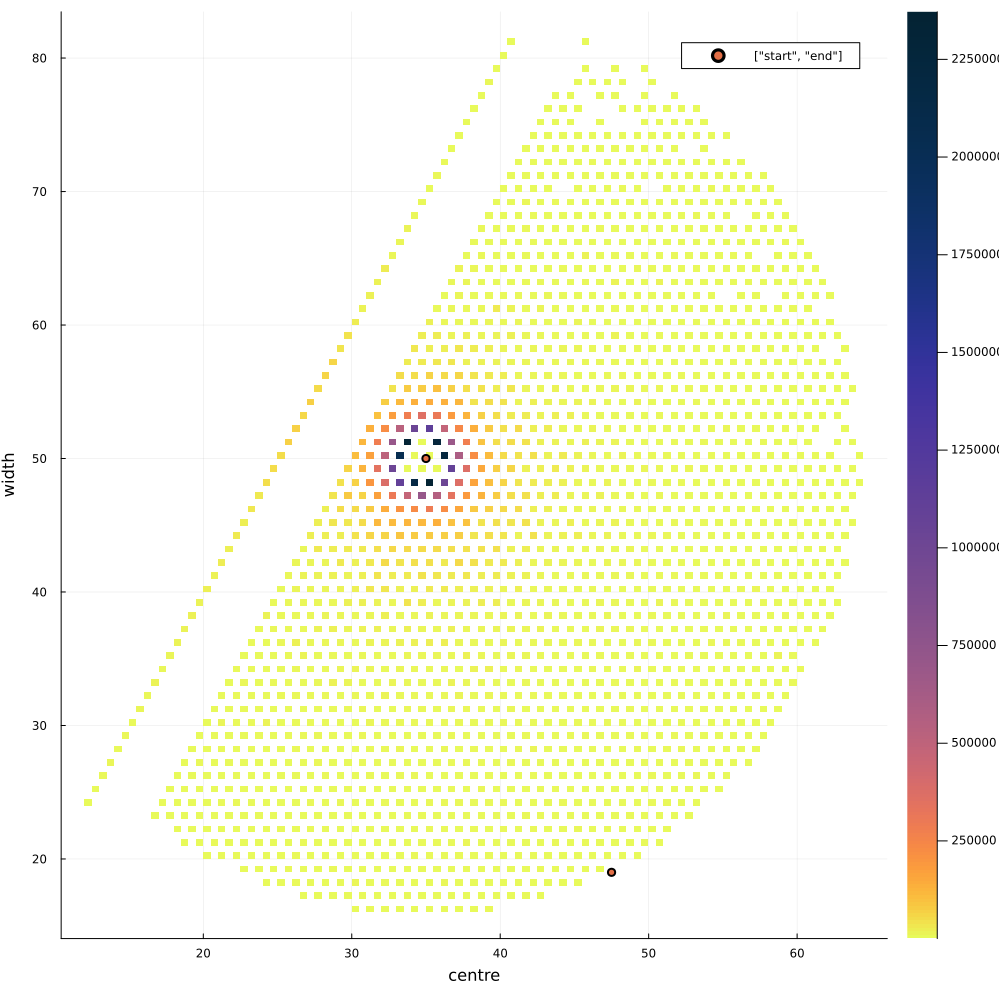

In [64]:
f = histogram2d(all_cw_m[1,:],all_cw_m[2,:],xaxis = "centre",yaxis = "width",bins = 200, size = (1000,1000),c = cgrad(:thermal, scale = :exp,rev = true))
scatter!(f,[(47.5, 19.0),(35.0,50.0)], label = ["start","end"])

You can see the start position and the end position. Interestingly it seems the space is explored fairly uniformly. You can see the feasable regions implied by the fitness function, e.g. the start position sits on a radius of a half circle centred on the target. 

Thoughts:
1. Appears to be some kind of 'resolution limit' to the system (hence the checkerboard pattern). Think this is due to the discretization of the system e.g. 100 cells make up the tissue, length 1 => cell resolution is 0.01
2. What is the valley? Think this is the minimum width I specify for a stripe to count, which gets violated somehow in this region (and hence not explored)
3. The upper hemisphere is when the stripe becomes absorbed by the left hand side hence no-longer passing crietria for "single stripe"



Reminder: these frequency plots take into account waiting time, rather than solely frequency of visit across runs

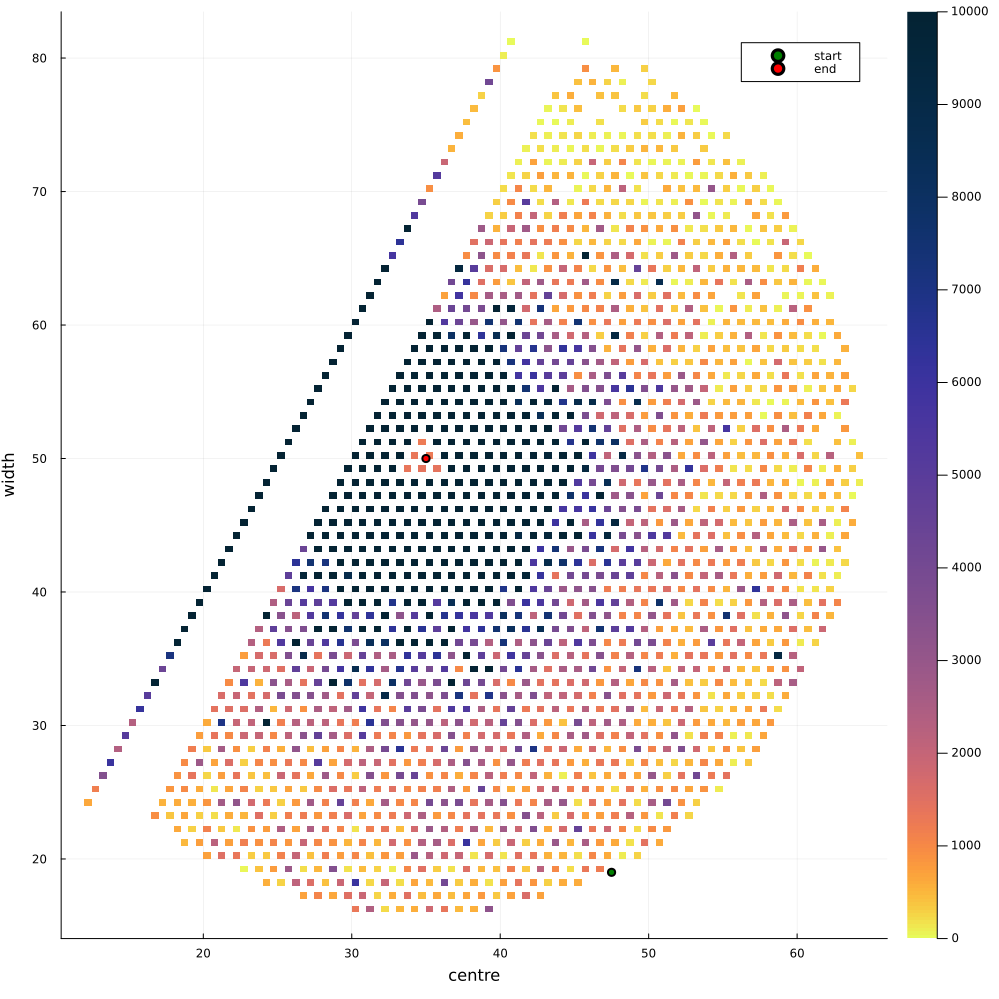

In [76]:
f = histogram2d(all_cw_m[1,:],all_cw_m[2,:],xaxis = "centre",yaxis = "width",bins = 200, size = (1000,1000),c = cgrad(:thermal, scale = :exp,rev = true),clims = (0.,10000.))
scatter!(f,[(47.5, 19.0)], label = "start",c = :green)
scatter!(f,[(35.0,50.0)], label = "end",c = :red)

Can see "man-made" artifacts of fitness function, leading to non-feasible regions. How to understand what the limitations of the sytem are fundamentally - phase space analysis

My guess is that this is why the genotype space analysis will look different - it gets put through the non-linear genotype mapping, and therefore non-feasible regions will be more to do with the model structure

In [80]:
cw = map(x->map(y->get_centres_and_width(y),unique(x)),all_class);

all_cw = reduce(vcat,cw);

all_cw_m = reduce(hcat,all_cw);

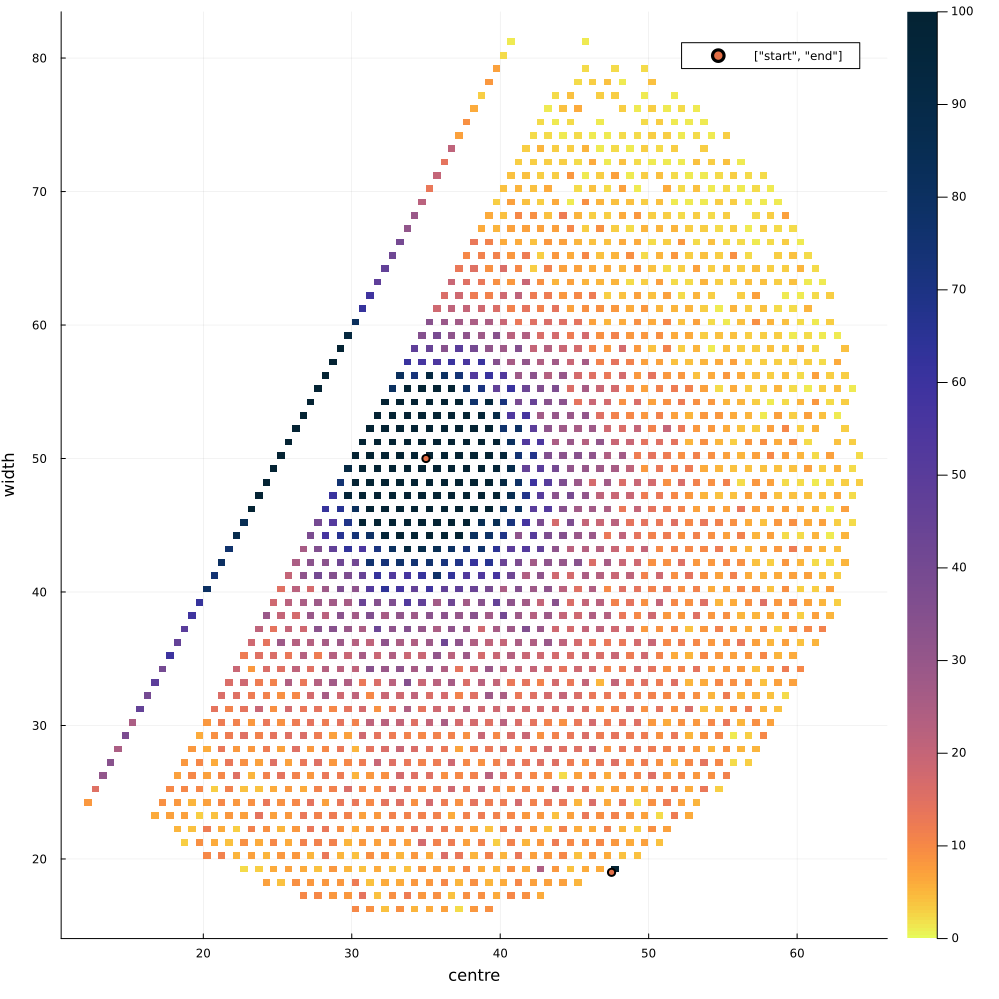

In [84]:
f = histogram2d(all_cw_m[1,:],all_cw_m[2,:],xaxis = "centre",yaxis = "width",bins = 200, size = (1000,1000),c = cgrad(:thermal, scale = :exp,rev = true),clims = (0.,100.))
scatter!(f,[(47.5, 19.0),(35.0,50.0)], label = ["start","end"])

wait times are stochastic on the mutation operator and possible the corresponding regions in genotype space. One question would be, are wait times in area of phenotype space explained statistically purely the stochastic nature of the mutation operator? or is more needed to explain, i.e. could it be that the associated regions in genotype space are "hard" to escape from.  